In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


#Web Scrapping
import requests
from bs4 import BeautifulSoup

#Data Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS

#Topic modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
website = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 50              # Total no. of pages selected for review extraction
page_size = 100

reviews = []            # object to store extracted reviews from website

for i in range(1, pages + 1):

    print(f"Scraping data from Page {i}")

    # Create URL to collect links
    url = f"{website}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"


    response = requests.get(url)     # Collect HTML data from this page

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} Total Reviews")

Scraping data from Page 1
   ---> 100 Total Reviews
Scraping data from Page 2
   ---> 200 Total Reviews
Scraping data from Page 3
   ---> 300 Total Reviews
Scraping data from Page 4
   ---> 400 Total Reviews
Scraping data from Page 5
   ---> 500 Total Reviews
Scraping data from Page 6
   ---> 600 Total Reviews
Scraping data from Page 7
   ---> 700 Total Reviews
Scraping data from Page 8
   ---> 800 Total Reviews
Scraping data from Page 9
   ---> 900 Total Reviews
Scraping data from Page 10
   ---> 1000 Total Reviews
Scraping data from Page 11
   ---> 1100 Total Reviews
Scraping data from Page 12
   ---> 1200 Total Reviews
Scraping data from Page 13
   ---> 1300 Total Reviews
Scraping data from Page 14
   ---> 1400 Total Reviews
Scraping data from Page 15
   ---> 1500 Total Reviews
Scraping data from Page 16
   ---> 1600 Total Reviews
Scraping data from Page 17
   ---> 1700 Total Reviews
Scraping data from Page 18
   ---> 1800 Total Reviews
Scraping data from Page 19
   ---> 1900 Total 

In [3]:
# Storing reviews in a pandas dataframe
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | We have sat on this plane fo...
1,Not Verified | British Airways stranding my w...
2,✅ Trip Verified | Although like many these d...
3,✅ Trip Verified | This flight was British Airw...
4,Not Verified | The worst airline I have ever f...


In [4]:
df.reviews= df.reviews.str.split('|',expand=True)[1] #split the text before and after the symbol |

In [5]:
df.head()

,reviews
0,We have sat on this plane for an hour and for...
1,British Airways stranding my wife and I at H...
2,"Although like many these days, I avoid BA o..."
3,This flight was British Airways at its very b...
4,The worst airline I have ever flown with. The...


In [6]:
def replace(text):            # Define a function to clean the text
    text = re.sub(r'[^A-Za-z]+', ' ', str(text)) # Replaces all special characters and numericals with blanks and leaving the words
    return text
# Cleaning the text in the review column
df['reviews']= df["reviews"].apply(replace)
df.head()

,reviews
0,We have sat on this plane for an hour and for...
1,British Airways stranding my wife and I at He...
2,Although like many these days I avoid BA on l...
3,This flight was British Airways at its very b...
4,The worst airline I have ever flown with They...


In [7]:
df['reviews'] = df['reviews'].str.lower() #lowercase

In [8]:
df.head()

,reviews
0,we have sat on this plane for an hour and for...
1,british airways stranding my wife and i at he...
2,although like many these days i avoid ba on l...
3,this flight was british airways at its very b...
4,the worst airline i have ever flown with they...


In [9]:
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '') #remove the pontuation

In [10]:
df.head()

,reviews
0,we have sat on this plane for an hour and for...
1,british airways stranding my wife and i at he...
2,although like many these days i avoid ba on l...
3,this flight was british airways at its very b...
4,the worst airline i have ever flown with they...


In [11]:
df['reviews'] = df['reviews'].str.replace('\d', '') #remove numbers

In [12]:
df.head()

,reviews
0,we have sat on this plane for an hour and for...
1,british airways stranding my wife and i at he...
2,although like many these days i avoid ba on l...
3,this flight was british airways at its very b...
4,the worst airline i have ever flown with they...


In [13]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /Users/em/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
df['reviews'] = df['reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviews'].head(10)

0    we have sat on this plane for an hour and fort...
1    british airway stranding my wife and i at heat...
2    although like many these day i avoid ba on lon...
3    this flight wa british airway at it very best ...
4    the worst airline i have ever flown with they ...
5    disappointing service plane interior and terri...
6    a transit visa is required for my partner to t...
7    i wa surprised to receive confirmation pre fli...
8    flight cancelled not refunding our money sayin...
9    i had visa issue and hence wa debarred from fl...
Name: reviews, dtype: object

In [15]:
df.head()

,reviews
0,we have sat on this plane for an hour and fort...
1,british airway stranding my wife and i at heat...
2,although like many these day i avoid ba on lon...
3,this flight wa british airway at it very best ...
4,the worst airline i have ever flown with they ...


#### Vectorizing Raw Text: a machine can read in bits and numbers and therefore we will first need to convert our text into numbers.

In [16]:
cv = CountVectorizer()
x = cv.fit_transform(reviews)         # Fitting the vectorizer to the dataset

In [17]:
x

<3895x14399 sparse matrix of type '<class 'numpy.int64'>'
	with 394399 stored elements in Compressed Sparse Row format>

#### Latent Dirichlet Allocation  
Model that uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

Reference: https://www.youtube.com/watch?v=4DsgCZ3KTNk 

In [ ]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [19]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [20]:
lda.fit(x)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

In [21]:
def vadersentimentanalysis(review):   #sentiment analysis
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['reviews'].apply(vadersentimentanalysis)


def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,reviews,Sentiment,Analysis
0,we have sat on this plane for an hour and fort...,-0.8364,Negative
1,british airway stranding my wife and i at heat...,-0.7506,Negative
2,although like many these day i avoid ba on lon...,-0.6663,Negative
3,this flight wa british airway at it very best ...,0.9833,Positive
4,the worst airline i have ever flown with they ...,-0.9081,Negative


In [22]:
analysis = df['Analysis'].value_counts()
analysis

Analysis
Neutral     1731
Negative    1083
Positive    1081
Name: count, dtype: int64

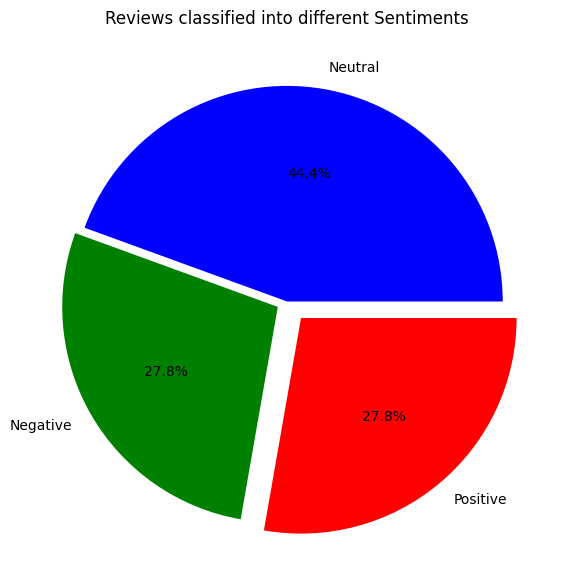

In [23]:
plt.figure(figsize=(25,7))
plt.subplot(1,3,2)
plt.title("Reviews classified into different Sentiments")
plt.pie(analysis.values, labels = analysis.index, explode = (0, 0.05, 0.1), autopct='%1.1f%%', shadow=False , colors=("blue", "green", "red"))
plt.show()

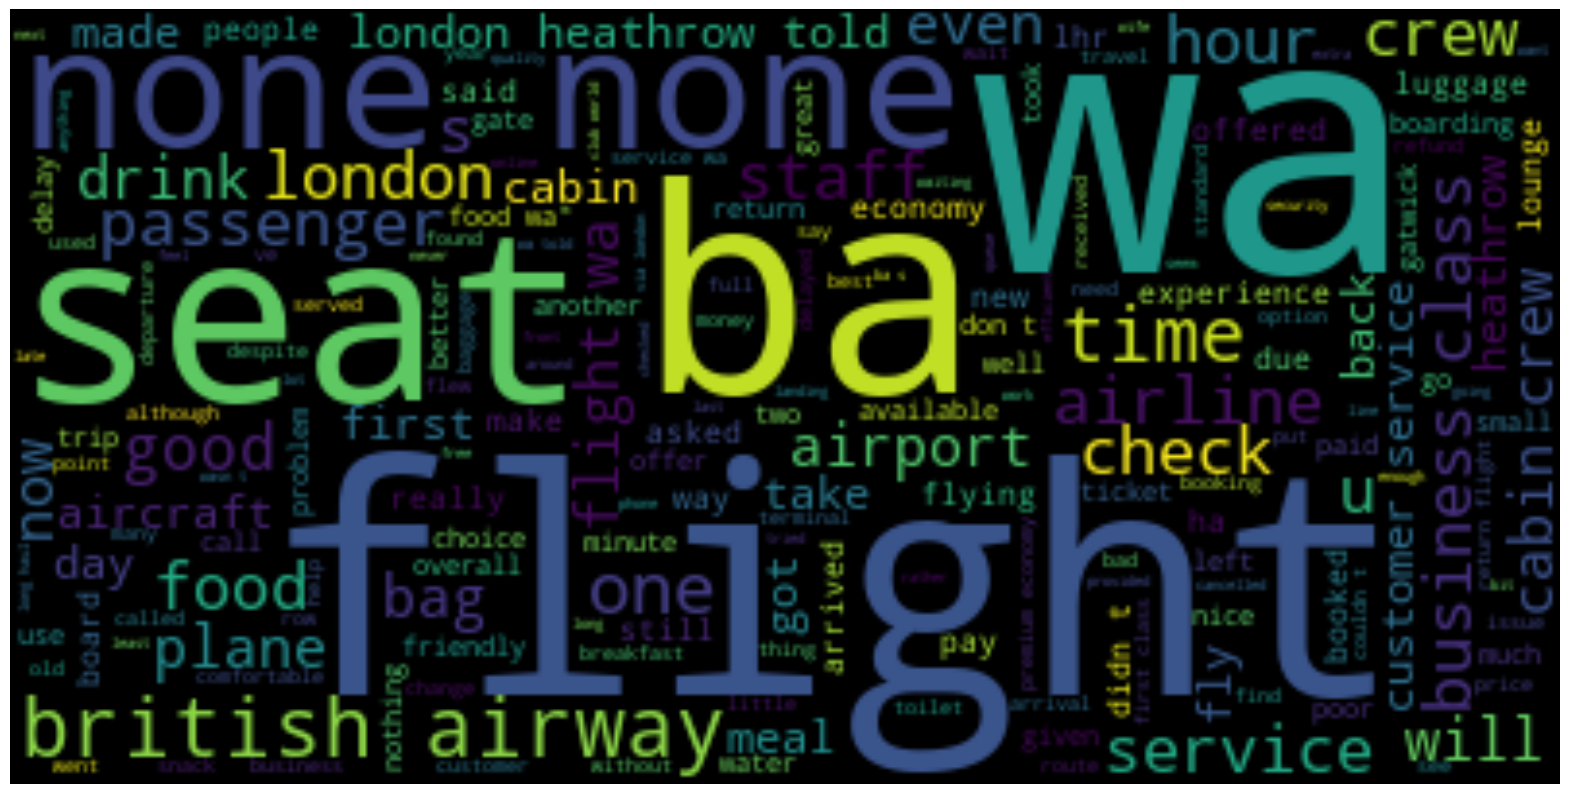

In [24]:
text = " ".join(i for i in df.reviews)   #wordcloud
wordcloud = WordCloud().generate(text)
fig = plt.figure(1, figsize=(20, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()